# This is a notebook for PMT gain estimation from calibration events
- Calculate pedestal RMS    
    - Load pedestal data and perform R0 correction
    - Check pedestal distribution and get RMS
- Analyze flat-fielding events
    - Choose data to be used
    - Briefly look at an event.
        - Check waveforms after R0 correction
        - Calibration from R1 to DL1
        - Check waveform and integration window 
        - Look at a camera image of the event
    - Estimate the number of p.e. from flat-fielding events
        - Extract charge from events and store them in an array
        - Check charge distribution in a pixel
        - Estimate the number of p.e. using excess noise factor method
        - See consistency between the number of p.e. estimated from high and low gain
        - Look at camera display of the estimated number of p.e.

### Data location
 You can download the data used in this notebook from http://www.icrr.u-tokyo.ac.jp/~yukihok/LSTdata/<p>
 You need user name and password to access the web page.<p>
 They are completely same as those needed for LST1 wiki http://www.lst1.iac.es/wiki/index.php/Main_Page/

### Import modules

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from ctapipe.calib import CameraCalibrator
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.io import event_source
from traitlets.config.loader import Config
import sys
sys.path.append('../../ctapipe_io_lst')  #add path to ctapipe_io_lst
from lstchain.calib.camera.r0 import LSTR0Corrections

### Prepare the class for R0 correction

In [2]:
config = Config({
    "LSTR0Corrections": {
        "pedestal_path": "/home/yukihok/Work/CTA/Analysis/calibration/pedestal_run97_new.fits",
        "offset": 300,
        "tel_id": 0, # for EVB3 will be 1
        "r1_sample_start": None,
        "r1_sample_end": None
    }
})
lst_r0 = LSTR0Corrections(config=config)

## Calculate pedestal RMS
### Load pedestal data and perform R0 correction

In [3]:
ped_input_url = '/disk/gamma/cta/work/yukiho/RealData/LST-1.1.Run00158.0000.fits.fz'
pedestal_source = event_source(input_url=ped_input_url, max_events = 1000)

In [4]:
tel_id = 0
pedestal = []
window_start = 12  # define window position for pedestal calculation
window_width = 7
for event in pedestal_source:
    if (event.count + 1) % 1000 == 0:
        print('{} events have been read.'.format(event.count + 1))
    #lst_r0.calibrate(event)
    lst_r0.subtract_pedestal(event)    
    #lst_r0.time_lapse_corr(event)
    #lst_r0.interpolate_spikes(event)
    event.r1.tel[tel_id].waveform = event.r1.tel[tel_id].waveform - lst_r0.offset
    pedestal.append(np.sum(event.r1.tel[tel_id].waveform[:, :, window_start:window_start + window_width], axis=2))

1000 events have been read.


### Check pedestal distribution and get RMS

the number of used pedestal events: 1000


<Figure size 432x288 with 0 Axes>

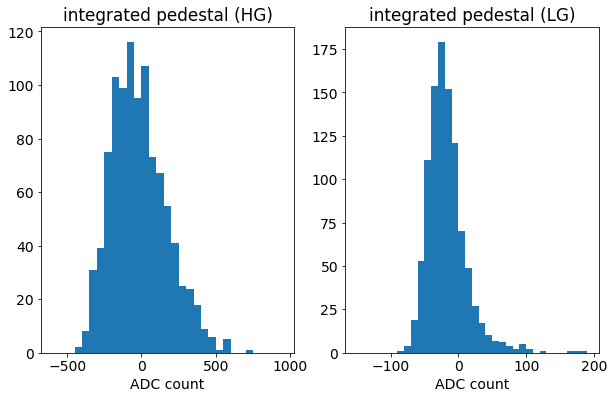

high gain: average -15.731, std 185.01414713205043 
low gain : average -16.56, std 33.64708605511033 


In [5]:
pedestal = np.array(pedestal)
pedestal_var = np.var(pedestal, axis=0) # used for gain estimation later
print('the number of used pedestal events:', pedestal.shape[0])
pix = 0

plt.subplots_adjust(wspace=40, hspace=0.6)
rcParams['figure.figsize'] = 10, 6
rcParams['font.size'] = 14
fig, ax = plt.subplots(1, 2)
ax[0].hist(pedestal[:, 0, pix], bins=np.arange(-600, 1000, 50))
ax[1].hist(pedestal[:, 1, pix], bins=np.arange(-150, 200, 10))
ax[0].set_title('integrated pedestal (HG)')
ax[1].set_title('integrated pedestal (LG)')
ax[0].set_xlabel('ADC count')
ax[1].set_xlabel('ADC count')
plt.show()
print('high gain: average {}, std {} '.format(np.mean(pedestal[:, 0, pix]), np.std(pedestal[:, 0, pix])))
print('low gain : average {}, std {} '.format(np.mean(pedestal[:, 1, pix]), np.std(pedestal[:, 1, pix])))

# Analyze flat-fielding events
## The flat-fielding data to be used

In [6]:
ff_input_url = '/disk/gamma/cta/store/ZFITS2/CalibPulse/LST-1.1.Run00170.0000.fits.fz'  # path to the flat-fielding data 

## First, let's look at an event briefly

In [7]:
ff_source = event_source(input_url=ff_input_url, max_events=2)  # The first event should be excluded from the analysis.
for event in ff_source:
    print('event id: {}'.format(event.count))

event id: 0
event id: 1


### Check waveforms after R0 correction

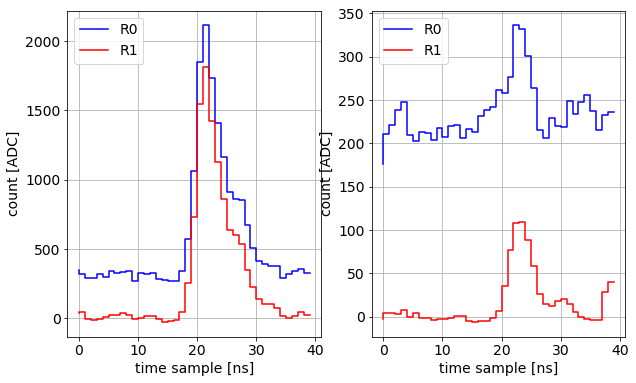

In [8]:
t = np.arange(0, 40, 1)
pix = 1

fig, ax = plt.subplots(1, 2)
ax[0].step(t, event.r0.tel[tel_id].waveform[0, pix], color="blue", label="R0")
ax[1].step(t, event.r0.tel[tel_id].waveform[1, pix], color="blue", label="R0")

#lst_r0.calibrate(event)
lst_r0.subtract_pedestal(event)
event.r1.tel[tel_id].waveform = event.r1.tel[tel_id].waveform - lst_r0.offset
#lst_r0.time_lapse_corr(event)
#lst_r0.interpolate_spikes(event)

ax[0].step(t, event.r1.tel[tel_id].waveform[0, pix], color="red", label="R1")
ax[1].step(t, event.r1.tel[tel_id].waveform[1, pix], color="red", label="R1")

axs = plt.gcf().get_axes()
for ax in axs:
    plt.sca(ax)
    plt.xlabel("time sample [ns]")
    plt.ylabel("count [ADC]")
    plt.legend(loc='upper left')
    plt.grid()
plt.show()

### Calibration from R1 to DL1

In [9]:
calibrator = CameraCalibrator(extractor_product = 'LocalPeakIntegrator', eventsource=ff_source)
event.r1.tel[tel_id].waveform[:, :, :2] = 0  # to avoid the edge of ROI being chosen as a peak.
event.r1.tel[tel_id].waveform[:, :, 38:] = 0
#calibrator.r1.calibrate(event)
if tel_id not in event.r1.tels_with_data:
    event.r1.tels_with_data.append(tel_id)
calibrator.dl0.reduce(event)
if tel_id not in event.dl0.tels_with_data:
    event.dl0.tels_with_data.append(tel_id)
calibrator.dl1.calibrate(event)

### Check waveform and integration window 

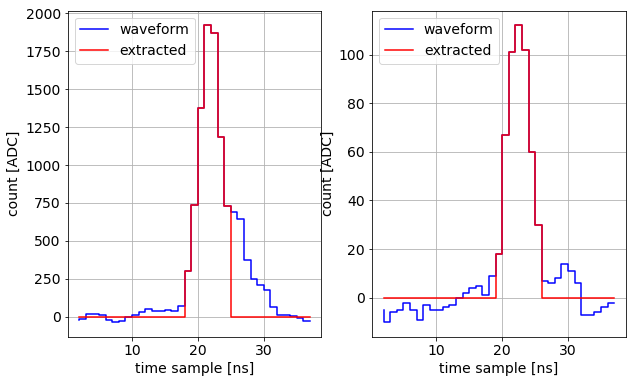

In [10]:
pix = 0
t = np.arange(2, 38, 1)
fig, ax = plt.subplots(1, 2)
ax[0].step(t, event.dl0.tel[tel_id].waveform[0, pix, 2:38], color="blue", label="waveform")
ax[1].step(t, event.dl0.tel[tel_id].waveform[1, pix, 2:38], color="blue", label="waveform")
ax[0].step(
    t, 
    event.dl0.tel[tel_id].waveform[0, pix, 2:38]*event.dl1.tel[tel_id].extracted_samples[0, pix, 2:38],
    color="red", 
    label="extracted"
)
ax[1].step(
    t,
    event.dl0.tel[tel_id].waveform[1, pix, 2:38]*event.dl1.tel[tel_id].extracted_samples[1, pix, 2:38],
    color="red",
    label="extracted"
)
axs = plt.gcf().get_axes()
for ax in axs:
    plt.sca(ax)
    plt.xlabel("time sample [ns]")
    plt.ylabel("count [ADC]")
    plt.legend(loc='upper left')
    plt.grid()
plt.show()

### Look at a camera image of the event

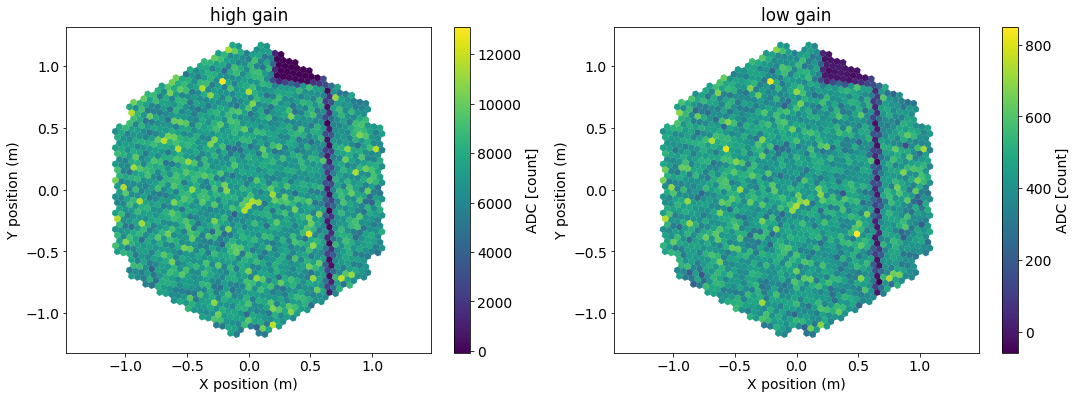

In [11]:
plt.rcParams['figure.figsize'] = (18, 6)
camera = CameraGeometry.from_name("LSTCam", 2)
plt.subplot(1,2,1)
display = CameraDisplay(camera)
display.image = event.dl1.tel[tel_id].image[0]
display.add_colorbar()
display.colorbar.set_label('ADC [count]')
#display.set_limits_minmax(0, 100)
plt.title('high gain')
plt.subplot(1,2,2)
display = CameraDisplay(camera)
display.image = event.dl1.tel[tel_id].image[1]
display.add_colorbar()
display.colorbar.set_label('ADC [count]')
plt.title('low gain')
plt.show()

## Estimate the number of p.e. from flat-fielding events 
### Extract charge from events and store them in an array

In [12]:
max_events = 4000
threshold = 1000
ff_source = event_source(input_url = ff_input_url, max_events = max_events)
calibrator = CameraCalibrator(extractor_product = 'LocalPeakIntegrator', eventsource=ff_source)
hg_charge = []
lg_charge = []
num_events = 0
print ('analyzing', ff_input_url) 
for event in ff_source:
    if event.count == 0:  # We don't use the first event.
        continue;
    if (event.count + 1) % 1000 == 0:
        print('{} events have been read.'.format(event.count + 1))
    #lst_r0.calibrate(event)
    lst_r0.subtract_pedestal(event)    
    #lst_r0.time_lapse_corr(event)
    #lst_r0.interpolate_spikes(event)
    event.r1.tel[tel_id].waveform = event.r1.tel[tel_id].waveform - lst_r0.offset
    event.r1.tel[tel_id].waveform[:, :, :2] = 0 # to avoid the edge of ROI being chosen as a peak.
    event.r1.tel[tel_id].waveform[:, :, 38:] = 0
    if tel_id not in event.r1.tels_with_data:
        event.r1.tels_with_data.append(tel_id)
    calibrator.dl0.reduce(event)
    if tel_id not in event.dl0.tels_with_data:
        event.dl0.tels_with_data.append(tel_id)
    calibrator.dl1.calibrate(event)
    if np.mean(event.dl1.tel[tel_id].image[0, :]) > threshold:  # to exclude events triggered by NSB/muon/shower.
        hg_charge.append(event.dl1.tel[tel_id].image[0, :])
        lg_charge.append(event.dl1.tel[tel_id].image[1, :])
        num_events = num_events + 1
        
num_gains = 2
num_pixels = 1855
charge = np.zeros((num_gains, num_events, num_pixels))  # This array contains all the charge information.
charge[0] = np.array(hg_charge)
charge[1] = np.array(lg_charge)
print('')
print(num_events, 'events are used for gain estimation.')

analyzing /disk/gamma/cta/store/ZFITS2/CalibPulse/LST-1.1.Run00170.0000.fits.fz
1000 events have been read.
2000 events have been read.
3000 events have been read.
4000 events have been read.

3987 events are used for gain estimation.


### Check charge distribution in a pixel

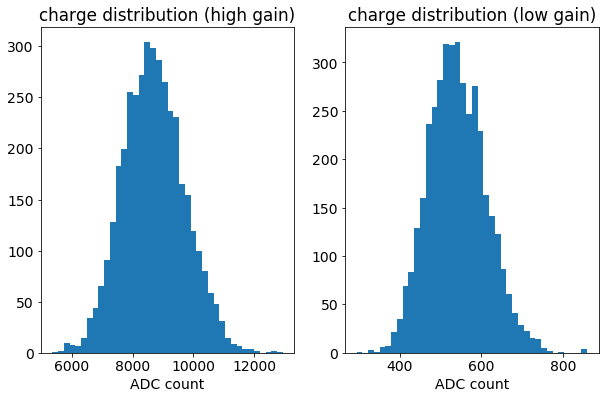

HG: average 8693.259593679459   std 1017.8173690399834
LG: average 541.4103335841485   std 70.4259474149214


In [13]:
pix = 0
rcParams['figure.figsize'] = 10, 6
fig, ax = plt.subplots(1, 2)
ax[0].hist(charge[0, :, pix], bins=40)
#ax[0].set_yscale('log')
ax[0].set_title('charge distribution (high gain)')
ax[0].set_xlabel('ADC count')
ax[1].hist(charge[1, :, pix], bins=40)
#ax[1].set_yscale('log')
ax[1].set_title('charge distribution (low gain)')
ax[1].set_xlabel('ADC count')
plt.show()
print('HG:', 'average', np.mean(charge[0, :, pix]), '  std', np.std(charge[0, :, pix]))
print('LG:', 'average', np.mean(charge[1, :, pix]),'  std', np.std(charge[1, :, pix]))

### Estimate the number of p.e. using excess noise factor method

In [14]:
mean_charge = np.mean(charge, axis=1)
var_charge = np.var(charge, axis=1)
F_square = 1.2  # square of ENF based on measurement
phe = mean_charge*mean_charge/(var_charge-pedestal_var)*F_square

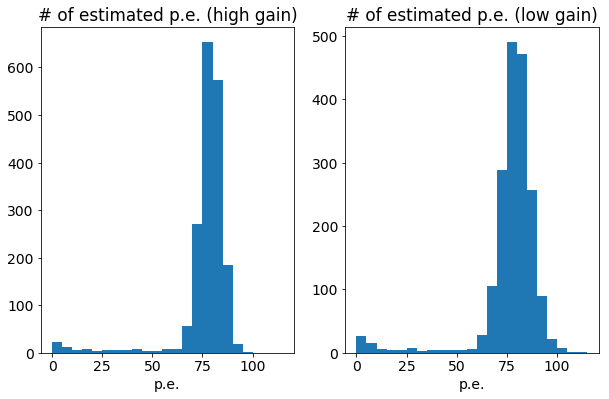

HG: average 76.3894339549488   std 13.829187856982118
LG: average 76.82790272722201   std 15.17962250570576


In [15]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(phe[0], bins=np.arange(0, 120, 5))
ax[0].set_title('# of estimated p.e. (high gain)')
ax[0].set_xlabel('p.e.')
ax[1].hist(phe[1], bins=np.arange(0, 120, 5))
ax[1].set_title('# of estimated p.e. (low gain)')
ax[1].set_xlabel('p.e.')
plt.show()
print('HG:', 'average', np.mean(phe[0]), '  std', np.std(phe[0]))
print('LG:', 'average', np.mean(phe[1]), '  std', np.std(phe[1]))

### See consistency between the number of p.e. estimated from high and low gain

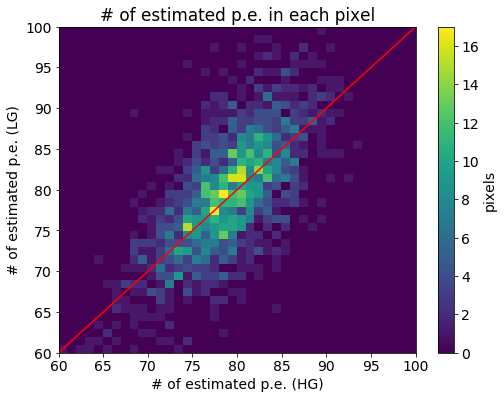

In [16]:
t = np.linspace(0, 200, 200)
phe_range = [60, 100]
tick = phe_range[1] - phe_range[0]
plt.rcParams['figure.figsize'] = (8, 6)
plt.figure()
plt.hist2d(phe[0], phe[1], range=[phe_range, phe_range], bins = [tick, tick])
plt.plot(t, t, color='r')
plt.xlabel('# of estimated p.e. (HG)')
plt.ylabel('# of estimated p.e. (LG)')
plt.title('# of estimated p.e. in each pixel')
cb = plt.colorbar()
cb.set_label('pixels')
plt.show()

### Display the estimated number of p.e. on the camera

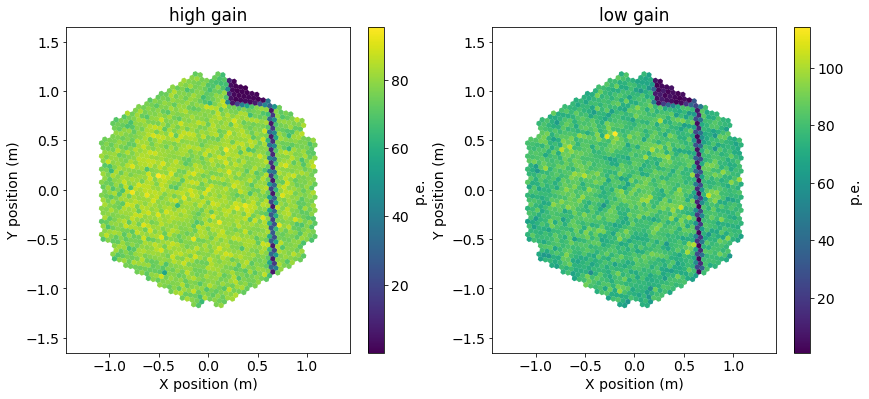

In [17]:
camera = CameraGeometry.from_name("LSTCam", 2)
plt.rcParams['figure.figsize'] = (14, 6)
plt.subplot(1,2,1)
display = CameraDisplay(camera)
display.image = phe[0]
display.add_colorbar()
display.colorbar.set_label('p.e.')
#display.set_limits_minmax(0, 100)
plt.title('high gain')
plt.subplot(1,2,2)
display = CameraDisplay(camera)
display.image = phe[1]
display.add_colorbar()
display.colorbar.set_label('p.e.')
#display.set_limits_minmax(0, 100)
plt.title('low gain')
plt.show()